# Evaluation of the GAN

# 1. Import Libaries

In [4]:
import os
import shutil
import sys
sys.path.append('../src/models/')
sys.path.append('../src/utils/')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as dset
from torchvision import transforms
from torch import autograd
import torch.optim as optim

import matplotlib.pyplot as plt

from GNet256_Greyscale import OptGenGreyscale256
from DNet256 import OptDis256

import ignite
import ignite.distributed as idist
from ignite.metrics import FID, InceptionScore

from ignite.engine import Engine
from ignite.handlers import *
import PIL.Image as Image

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Set Parameters

In [2]:
cadastralRootGreyscale = '../../cadastralExport'
image_size = 256
batch_size = 20
workers = 2
nz = 2**4*4*4 # Size of z latent vector (i.e. size of generator input)
lr = 0.0002 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers

ngpu = torch.cuda.device_count() # Number of GPUs available. Use 0 for CPU mode.
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# device = 'cpu'

# 3. Import Real Images

In [54]:
# We can use an image folder dataset the way we have it setup
if os.path.exists(cadastralRootGreyscale + '/.ipynb_checkpoints'):
    shutil.rmtree(cadastralRootGreyscale + '/.ipynb_checkpoints')

Cad_dataset_greyscale = dset.ImageFolder(root=cadastralRootGreyscale,
                           transform=transforms.Compose([
                               transforms.RandomRotation(degrees=(0,180), expand = False),
                               transforms.CenterCrop(image_size * 2),
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               # transforms.Grayscale(num_output_channels=1)
                           ]))
# Create the dataloader
Cad_dataloader_greyscale = torch.utils.data.DataLoader(Cad_dataset_greyscale, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Load some training images
xr = next(iter(Cad_dataloader_greyscale))

In [55]:
Cad_dataset_greyscale

Dataset ImageFolder
    Number of datapoints: 2569
    Root location: ../../cadastralExport
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[0.0, 180.0], interpolation=nearest, expand=False, fill=0)
               CenterCrop(size=(512, 512))
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

# 4. Import Model

In [56]:
NetG64 = torch.load('../models/Greyscale256_NetG_Training').to(device)
NetD64 = torch.load('../models/Greyscale256_NetD_Training').to(device)

In [62]:
z = torch.randn(batch_size, nz, 1, 1, device=device)
xf = NetG64.forward(z)
xf = xf + 1e+0 * torch.randn(*xf.size(), device=device)

In [63]:
xf[0][0]

tensor([[-0.3952, -0.2585,  0.9271,  ..., -0.1189, -0.0871,  0.6791],
        [-2.2896,  0.2911, -1.3935,  ..., -0.7593,  0.5989,  0.9174],
        [-1.1506, -2.4709, -0.2671,  ...,  1.2542, -1.9109,  0.6901],
        ...,
        [-0.0419, -0.2764, -0.4473,  ...,  0.0150, -0.3420,  0.7958],
        [ 0.8347, -2.9096, -1.7758,  ..., -1.0877, -0.7847,  0.0775],
        [ 0.5356,  0.0183,  0.5051,  ...,  1.6085, -1.4679,  1.6989]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [73]:
if torch.linalg.matrix_rank(xf[0][0]) ==  256:
    print('Ok')

Ok


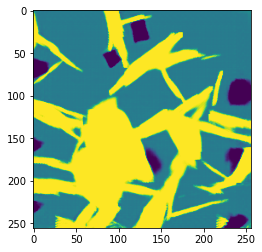

In [81]:
plt.imshow(xf[0].detach().cpu().permute(1,2,0))

# 5. Calculating FID

## 5.1 Define training steps
even if no training is needed this notebooks follows the example from ignite https://pytorch-ignite.ai/blog/gan-evaluation-with-fid-and-is/ step by step

In [35]:
def training_step(engine, data):
    return({'train':False})

In [36]:
trainer = Engine(training_step)

## 5.2 Calculate metrics

In [38]:
is_metric = InceptionScore(device=device, output_transform=lambda x: x[0])

In [6]:
def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299, 299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)

In [89]:
def evaluation_step(engine, batch):
    # pic_counter = 0
    with torch.no_grad():
        # pic_counter += batch[0].size(0)
        noise = torch.randn(batch[0].size(0), nz, 1, 1, device=device)
        NetG64.eval()
        # import code 
        # code.interact(local=dict(globals(), **locals()))
        fake_batch = NetG64.forward(noise)
        # fake_batch = fake_batch + 1e-6 * torch.randn(*fake_batch.size(), device=device)
        # for i in range(len(fake_batch)):
        #     rank = torch.linalg.matrix_rank(fake_batch[i][0])
        #     if rank != image_size:
        #         print(f'Found image with not full rank of: {rank}')
        fake_batch = fake_batch.repeat(1, 3, 1, 1)
        # print(f'fake batch size: {fake_batch.size()}')
        # print(f'real batch size: {batch[0].size()}')
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        # print(f'fake batch size after interpolation: {fake.size()}')
        # print(f'real batch size after interpolation: {real.size()}')
        # print(f'total number of pics seen: {pic_counter}')
        return fake, real

In [103]:
evaluatorIS = Engine(evaluation_step)

In [104]:
is_metric.attach(evaluatorIS, "is")

fid_values = []
is_values = []

evaluatorIS.run(Cad_dataloader_greyscale, max_epochs=2)
metrics = evaluatorIS.state.metrics
# fid_score = metrics['fid']
is_score = metrics['is']
# fid_values.append(fid_score)
is_values.append(is_score)

In [105]:
is_values

[2.8527517465210424]

In [106]:
evaluatorIS.state.metrics

{'is': 2.8527517465210424}

### Inception Score
2.981063175725717

In [1]:
# example of calculating the frechet inception distance
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm

# calculate frechet inception distance
def calculate_fid(act1, act2):
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

# define two collections of activations
act1 = random(10*2048)
act1 = act1.reshape((10,2048))
act2 = random(10*2048)
act2 = act2.reshape((10,2048))
# fid between act1 and act1
fid = calculate_fid(act1, act1)
print('FID (same): %.3f' % fid)
# fid between act1 and act2
fid = calculate_fid(act1, act2)
print('FID (different): %.3f' % fid)

FID (same): -0.000
FID (different): 355.650


In [90]:
# fid_metric = FID(device=device, num_features = 1024) 
# IDEA: change the number of feature, but still the dataset is larger than 2048, which 
# is the output
# not possible to change the number of feature, without changing the model for feat extraction...
fid_metric = FID(device=device)

In [91]:
evaluatorFID = Engine(evaluation_step)
fid_metric.attach(evaluatorFID, "fid")
fid_values = []

evaluatorFID.run(Cad_dataloader_greyscale, max_epochs=2)
metrics = evaluatorFID.state.metrics
fid_score = metrics['fid']
fid_values.append(fid_score)

Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full rank of: 255
Found image with not full

Engine run is terminating due to exception: Imaginary component 1.396992337264449e+216


ValueError: Imaginary component 1.396992337264449e+216

### Manual Inception Score

In [63]:
import numpy as np
from scipy import linalg
import warnings

def fid(mn1, cov1, mn2, cov2, eps=1e-6):
    mn1 = np.atleast_1d(mn1)
    mn2 = np.atleast_1d(mn2)
    
    cov1 = np.atleast_2d(cov1)
    cov2 = np.atleast_2d(cov2)
    
    diff = mn1 - mn2
        
    # product might be almost singular
    covmean, _ = linalg.sqrtm(cov1.dot(cov2), disp=False)
    if not np.isfinite(covmean).all():
        warnings.warn(("fid() got singular product; adding {} to diagonal of "
                       "cov estimates").format(eps))
        offset = np.eye(d) * eps
        covmean = linalg.sqrtm((cov1 + offset).dot(cov2 + offset))

    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(cov1) + np.trace(cov2) - 2 * tr_covmean

In [66]:
sample = next(iter(Cad_dataloader_greyscale))[0]
sample.size()

torch.Size([64, 3, 256, 256])

In [73]:
sampleUS = interpolate(sample)

In [75]:
fid_metric

### Frechet Inception Distance


In [28]:
noise = torch.randn(64, nz, 1, 1, device=idist.device())
fake_batch = NetG64(noise)

In [29]:
fake_batch.size()

torch.Size([64, 1, 256, 256])

In [30]:
fake_batch_rgb=fake_batch.repeat(1,3,1,1)

In [31]:
fake_batch_rgb.size()

torch.Size([64, 3, 256, 256])

In [24]:
noisergb=noise.repeat(1,3,1,1)

In [25]:
noisergb.size()

torch.Size([64, 768, 1, 1])

In [27]:
noise.size()

torch.Size([64, 256, 1, 1])

In [ ]:
### arr = []
### for i in range(xr[0].size(0)):
###     pil_img = transforms.ToPILImage()(xr[0][i])
###     resized_img = pil_img.resize((299,299), Image.BILINEAR)
###     arr.append(transforms.ToTensor()(resized_img))
### arr[i].size()

In [ ]:
### xr_int = torch.stack(arr)
### print(f'real batch size after interpolation: {xr_int.size()}')

the training function is loaded from src/utils/OptimisationFunctions

In [172]:
from OptimisationFunctions import trainModel

In [187]:
### # Params for the trainModel function
### # device: torch.device, dataloader: torch.utils.data.dataloader.DataLoader, 
### #                optimizerG, optimizerD, 
### #                fixed_noise:torch.Tensor, folder: str, epochs: int = 10, nz: int = 100,
### #                experiment: str = 'WGANRGB',
### #                AlternativeTraining: int = 0, logger: logging.Logger = None
### optimizerG = optim.Adam(NetG64.parameters(), lr=lr, betas=(beta1, 0.999))
### optimizerD = optim.Adam(NetD64.parameters(), lr=lr, betas=(beta1, 0.999))

SyntaxError: invalid syntax (2315953629.py, line 9)

In [188]:
### trainer = Engine(trainModel(netG=NetG64, netD=NetD64, device=device, dataloader=Cad_dataloader_greyscale, 
###         optimizerG=optimizerG, optimizerD=optimizerD, fixed_noise=z, folder='../', epochs = 2, nz=nz, 
###        experiment = 'evalution_test'))

Epoch: 0/2 | D Learn: True | D Loss: 22059.916| ErrDReal: -9073.0088 | ErrDFake: 31132.8203 | GradPenality: 0.1043 | G Loss: -25721.2949


TypeError: [tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.3899,  ..., 0.3134, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.3252,  ..., 0.1913, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.2981,  ..., 0.3369, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.3178,  ..., 0.3536, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.3294,  ..., 0.3708, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.3038,  ..., 0.3651, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])] is not a callable object

torch.Size([3, 299, 299])

In [135]:
xr_int = torch.stack(arr)
print(f'real batch size after interpolation: {xr_int.size()}')

real batch size after interpolation: torch.Size([64, 3, 299, 299])


In [132]:
print(f'xr size = {xr[0].size()}') 
interpolated = interpolate(xr[0])
print(f'xr interpolated size = {interpolated.size()}') 

xr size = torch.Size([64, 3, 256, 256])
xr interpolated size = torch.Size([64, 3, 256, 256])


In [ ]:
metrics

In [87]:
fid_values = []
is_values = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(test_dataloader,max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    is_score = metrics['is']
    fid_values.append(fid_score)
    is_values.append(is_score)
    print(f"Epoch [{engine.state.epoch}/5] Metric Scores")
    print(f"*   FID : {fid_score:4f}")
    print(f"*    IS : {is_score:4f}")

NameError: name 'trainer' is not defined

In [86]:
def training(*args):
    trainer.run(train_dataloader, max_epochs=5)

In [62]:
fid_metric.attach(evaluator, "fid")

In [64]:
with torch.no_grad():
    state = evaluator.run([[xf, xr]])

In [65]:
state

In [57]:
def eval_step(engine, batch):
    return batch

In [58]:
default_evaluator = Engine(eval_step)

In [59]:
metric = FID(device=device)
metric.attach(default_evaluator, "fid")

In [60]:
y_true = torch.ones(10, 4)
y_pred = torch.ones(10, 4)
state = default_evaluator.run([[y_pred, y_true]])
print(state.metrics["fid"])

Current run is terminating due to exception: Inputs should be a tensor of dim 4, got 2
Engine run is terminating due to exception: Inputs should be a tensor of dim 4, got 2


ValueError: Inputs should be a tensor of dim 4, got 2

In [ ]:
def evaluation_step(engine, data):
    return

In [ ]:
evaluator = Engine(evaluation_step)

In [67]:
fid_metric = FID(device=device)
is_metric = InceptionScore(device=device, output_transform=lambda x: x[0])

In [47]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

NameError: name 'models' is not defined

In [33]:
def calculate_activation_statistics(images,model,batch_size=64, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [34]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [35]:
def calculate_fretchet(images_real,images_fake,model):
     mu_1, std_1 = calculate_activation_statistics(images_real,model,cuda=True)
     mu_2, std_2 = calculate_activation_statistics(images_fake,model,cuda=True)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

In [ ]:
calculate_fretchet(images_real=xr, images_fake=xf, model=)

In [44]:
FID.eval()

AttributeError: type object 'FID' has no attribute 'eval'